In [1]:
import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.patches import Rectangle

In [2]:
csv_files = glob.glob('./data/stock1-*.csv')
dfs = []

for file in csv_files:
    print(f'appending data from {file}')
    df = pd.read_csv(file)
    dfs.append(df)

appending data from ./data/stock1-2025-07-02-cleaned.csv
appending data from ./data/stock1-2025-07-07-cleaned.csv


In [3]:
combined_df = pd.concat(dfs, ignore_index=True)

In [4]:
# See https://docs.python.org/3/library/datetime.html
# The hour is not zero padded, so %-I
combined_df['DateTime'] = pd.to_datetime(
    combined_df['Date'] + ' ' + combined_df['Time'],
    format='%m/%d/%Y %I:%M %p',
)

In [5]:
# Remove duplicates keeping the first occurrence.
clean_df = combined_df.drop_duplicates(subset=['DateTime'], keep='first')

# Sort by timestamp to ensure proper chronological order.
clean_df = clean_df.sort_values('DateTime').reset_index(drop=True)

In [6]:
clean_df.to_csv('./data/stock1_combined_price_data.csv', index=False)

In [7]:
df = pd.read_csv('./data/stock1_combined_price_data.csv')

df['DateTime'] = pd.to_datetime(df['DateTime'])

In [8]:
df.tail(1)

,Date,Time,Open,High,Low,Close,Volume,Simple Moving Average - SMA - SMA(20),Simple Moving Average - SMA - SMA(50),Simple Moving Average - SMA - SMA(200),"Exponential Moving Average - EMA - EMA(9,Modern)","Exponential Moving Average - EMA - EMA(61,Modern)",Relative Strength Index - RSI - RSI(14),"MACD - MACD(12,26,9)",MACD - Histogram,"MACD - Signal Line(MACD(12,26,9),9,Modern)",DateTime
698,07/07/2025,4:01 PM,5815.92,5815.92,5815.92,5815.92,24500,5800.79225,5781.251798,5740.015317,5809.306295,5781.871398,70.111677,9.821663,0.65446,9.167203,2025-07-07 16:01:00


In [40]:
def plot_spread_analysis(df, desired_date):    
    recent_data = df[df['DateTime'].dt.date == desired_date].copy()
    
    # Get first 15 minutes (9:30 to 9:45).
    first_15min = recent_data[recent_data['DateTime'].dt.time <= datetime.time(9, 45)]
    max_15min = first_15min['High'].max()
    min_15min = first_15min['Low'].min()

    # Determine line color based on trend vs previous close.
    current_close = first_15min['Close'].iloc[-1]
    print(f'15min close: {current_close}')

    prev_dates = df[df['DateTime'].dt.date < desired_date]['DateTime'].dt.date.unique()
    if len(prev_dates) > 0:
        prev_date = max(prev_dates)  # Most recent date before today
        print(f'using {prev_date} as previous date')
        prev_close_data = df[df['DateTime'].dt.date == prev_date]
        prev_close = prev_close_data['Close'].iloc[-1]
        print(f'prev day close: {prev_close}')
        line_color = 'green' if current_close > prev_close else 'red'
    else:
        print('no data for previous day found')
        line_color = 'black'

    day_close = recent_data['Close'].iloc[-1]
    print(f'price at close: {day_close}')

    
    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[3, 1])
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # ===== MAIN CANDLESTICK CHART =====
    for i, (idx, row) in enumerate(recent_data.iterrows()):
        open_price = row['Open']
        close_price = row['Close']
        high_price = row['High']
        low_price = row['Low']
        
        # Determine candle color.
        color = 'green' if close_price > open_price else 'red'
        
        # Draw the high-low line.
        ax1.plot([i, i], [low_price, high_price], color=color, linewidth=1)
        
        # Draw the open-close rectangle.
        height = abs(close_price - open_price)
        bottom = min(open_price, close_price)
        rect = Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, alpha=0.7, edgecolor=color)
        ax1.add_patch(rect)
       
    # Plot horizontal lines for first 15min high/low.
    ax1.axhline(y=max_15min, color=line_color, linestyle='-', linewidth=3, alpha=0.3, label=f'15min High: {max_15min:.2f}')
    ax1.axhline(y=min_15min, color=line_color, linestyle='-', linewidth=3, alpha=0.3, label=f'15min Low: {min_15min:.2f}')
    ax1.axhline(y=prev_close, color='black', linestyle='--', linewidth=2, alpha=0.3, label=f'prev day close: {prev_close:.2f}')


    # Calculate where 10-minute marks would be on your x-axis
    first_time = recent_data['DateTime'].iloc[0]
    last_time = recent_data['DateTime'].iloc[-1]
    
    # Create 20-minute intervals
    tick_times = pd.date_range(
        start=first_time.floor('10min'),  # Round down to nearest 10-min
        end=last_time.ceil('10min'),      # Round up to nearest 10-min
        freq='30min'
    )
    
    # Convert these times to x-axis positions
    tick_positions = []
    total_duration = (last_time - first_time).total_seconds()
    for tick_time in tick_times:
        # Calculate position based on time elapsed
        time_elapsed = (tick_time - first_time).total_seconds()
        position = (time_elapsed / total_duration) * (len(recent_data) - 1)
        tick_positions.append(position)
    
    tick_labels = [t.strftime('%H:%M') for t in tick_times]
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(tick_labels, rotation=45)

    # Add vertical line at 9:45am.
    line_945_time = first_time.replace(hour=9, minute=45, second=0, microsecond=0)
    time_elapsed_945 = (line_945_time - first_time).total_seconds()
    position_945 = (time_elapsed_945 / total_duration) * (len(recent_data) - 1)
    ax1.axvline(x=position_945, color='black', linestyle='--', linewidth=1, alpha=0.7, label='9:45 AM')

    # Add vertical line at 3:00pm.
    line_3pm_time = first_time.replace(hour=15, minute=00, second=0, microsecond=0)
    time_elapsed_3pm = (line_3pm_time - first_time).total_seconds()
    position_3pm = (time_elapsed_3pm / total_duration) * (len(recent_data) - 1)
    ax1.axvline(x=position_3pm, color='black', linestyle='--', linewidth=1, alpha=0.7, label='3:00 PM')

    ax1.set_ylabel('Price ($)')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [41]:
df['DateTime'].iloc[0]

Timestamp('2025-06-26 16:00:00')

In [42]:
np.flip( df['DateTime'].dt.date.unique() )

array([datetime.date(2025, 7, 7), datetime.date(2025, 7, 3),
       datetime.date(2025, 7, 2), datetime.date(2025, 7, 1),
       datetime.date(2025, 6, 30), datetime.date(2025, 6, 27),
       datetime.date(2025, 6, 26)], dtype=object)

15min close: 5746.535
using 2025-07-03 as previous date
prev day close: 5640.0
price at close: 5815.92


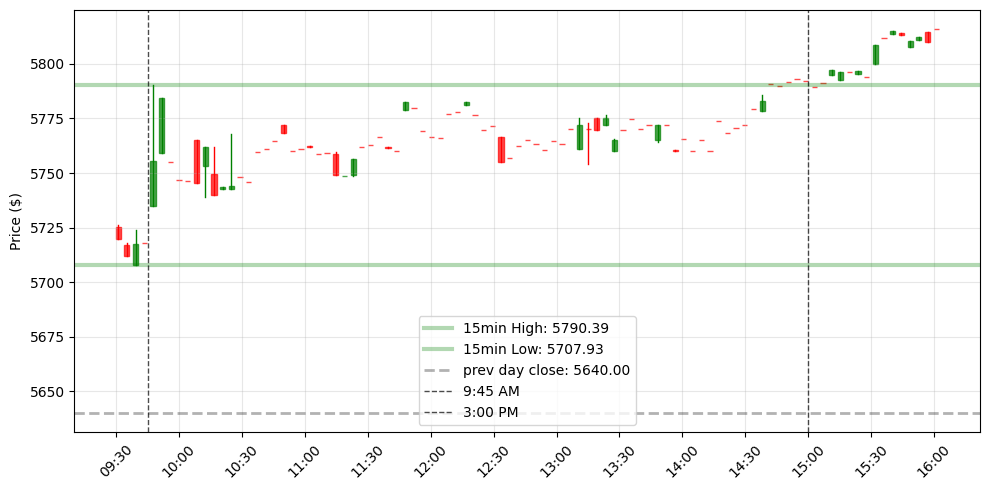

In [43]:
plot_spread_analysis(df, datetime.date(2025, 7, 7))

15min close: 5690.66
using 2025-07-02 as previous date
prev day close: 5701.76
price at close: 5640.0


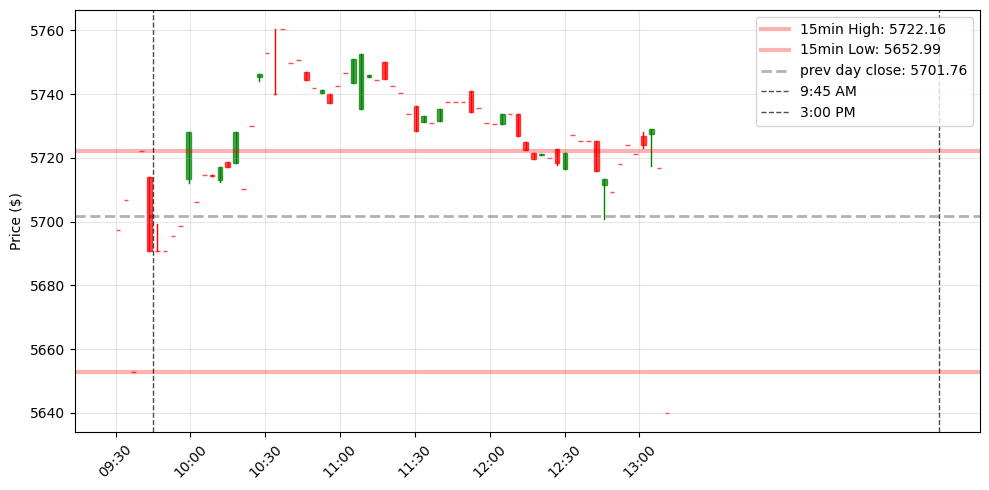

In [44]:
plot_spread_analysis(df, datetime.date(2025, 7, 3))

15min close: 5670.0
using 2025-07-01 as previous date
prev day close: 5730.73
price at close: 5701.76


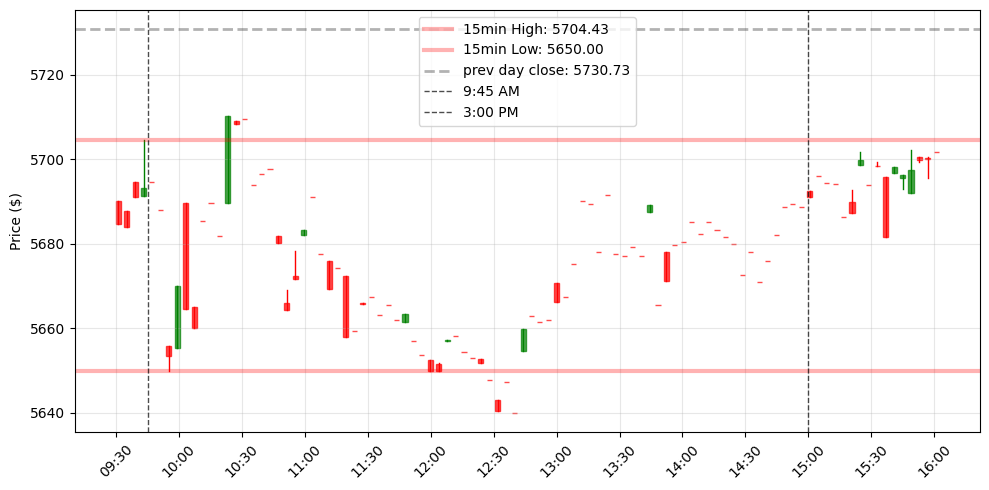

In [45]:
plot_spread_analysis(df, datetime.date(2025, 7, 2))

15min close: 5764.08
using 2025-06-30 as previous date
prev day close: 5789.24
price at close: 5730.73


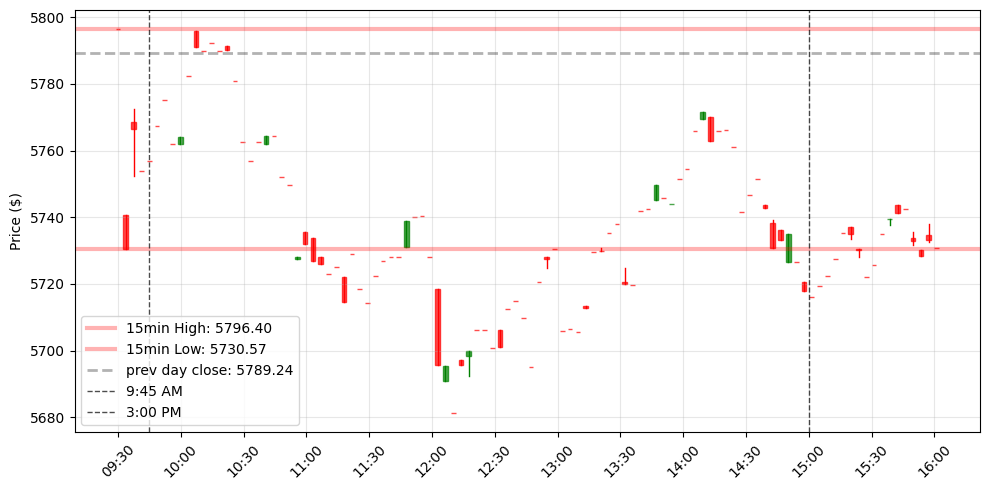

In [46]:
plot_spread_analysis(df, datetime.date(2025, 7, 1))

15min close: 5730.18
using 2025-06-27 as previous date
prev day close: 5693.1312
price at close: 5789.24


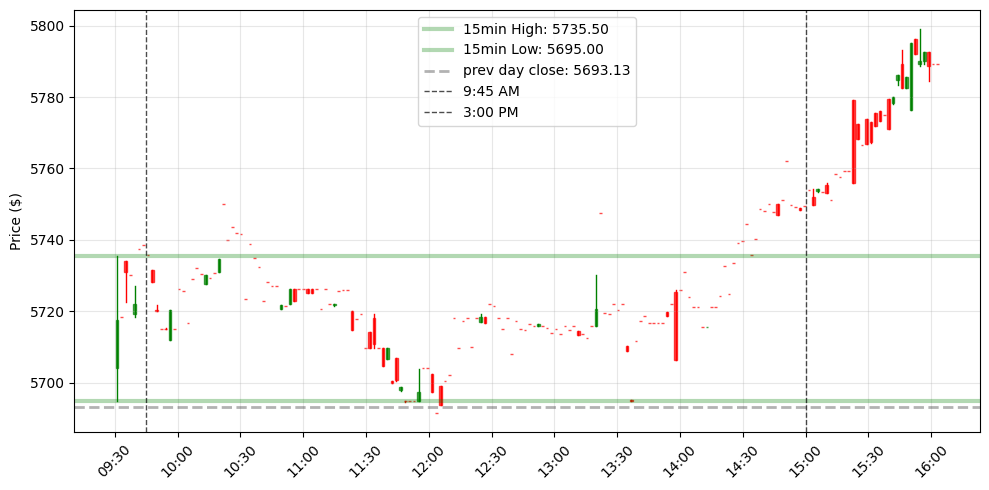

In [47]:
plot_spread_analysis(df, datetime.date(2025, 6, 30))

15min close: 5638.1
using 2025-06-26 as previous date
prev day close: 5596.0
price at close: 5693.1312


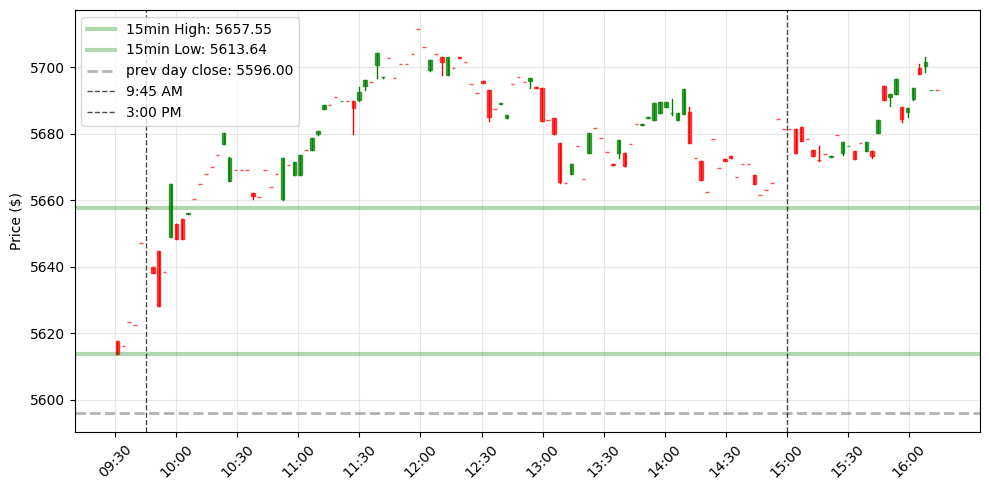

In [48]:
plot_spread_analysis(df, datetime.date(2025, 6, 27))